# Shapley values
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lazarusA/JuliaNotes/HEAD)

- Lazaro Alonso
- lalonso@bgc-jena.mpg.de

### References:
- https://expandingman.gitlab.io/Shapley.jl/
- Štrumbelj, Erik, and Igor Kononenko. "Explaining prediction models and individual predictions with feature contributions." Knowledge and information systems 41.3 (2014): 647-665
- Kjersti Aas, Martin Jullum and Anders Løland. Explaining individual predictions when features are dependent: More accurate approximations to Shapley values arXiv:1903.10464
- Lundberg, Scott and Lee, Su-In. "A Unified Approach to Interpreting Model Predictions" arXiv:1705.07874
- Lundberg, Scott and Erion, Gabriel and Lee, Su-In. "Consistent Individualized Feature Attribution for Tree Ensembles" arXiv:1802.03888
- Dominik Janzing and Lenon Minorics and Patrick Blöbaum. Feature relevance quantification in explainable AI: A causal problem. arXiv:1910.13413
- https://christophm.github.io/interpretable-ml-book/shapley.html

In [3]:
using Pkg
Pkg.status()

      Status `~/Documents/JuliaNotes/Project.toml`
  [336ed68f] CSV v0.10.2
  [13f3f980] CairoMakie v0.7.3
  [a93c6f00] DataFrames v1.3.2
  [add582a8] MLJ v0.17.1
  [c6f25543] MLJDecisionTreeInterface v0.1.3
  [ee78f7c6] Makie v0.16.4
  [855ca7ad] Shapley v0.1.1
  [10745b16] Statistics


### Loading packages

In [4]:
using MLJDecisionTreeInterface: RandomForestRegressor
using MLJ: fit!, machine, predict
using Shapley: MonteCarlo, shapley
using Statistics: cor, mean
using DataFrames: Not, DataFrame
using CSV
using CairoMakie
using Random

For this exercise let's consider the following data set. With GPP as the target and
temperature, precipitation, radiation and VPD as the input forcing variables.

In [5]:
data = CSV.read("./data/gpp.csv", DataFrame)
y, X = data[!, :GPP], data[!, Not(:GPP)]

([-0.152785, -0.272819, -0.509925, -0.503296, 0.0643858, -0.195346, -0.127031, -0.057065, -0.026408, -0.322352  …  -0.336354, 0.14397, 0.396827, 0.152733, -0.206312, 0.262416, 0.363505, 0.170179, -0.0969954, 0.0482463], 5086×4 DataFrame
  Row │ Ta_m     P_m      SWin_m   VPD_m   
      │ Float64  Float64  Float64  Float64 
──────┼────────────────────────────────────
    1 │  -0.512      1.6   53.792    0.761
    2 │  -0.213      0.0   38.333    0.581
    3 │  -0.425      0.0   82.854    0.755
    4 │  -1.175      0.0   58.021    0.607
    5 │  -0.365      0.0   99.146    1.518
    6 │  -3.419      0.0   16.646    1.547
    7 │  -1.283      0.2   29.958    1.302
    8 │   2.19       0.0   52.875    1.5
    9 │   3.429      6.6   14.458    1.104
   10 │   1.419      0.2  103.479    2.424
   11 │   4.062      0.0  103.271    4.855
  ⋮   │    ⋮        ⋮        ⋮        ⋮
 5077 │   3.161      9.8   16.76     0.229
 5078 │   4.446      4.4   29.507    0.43
 5079 │  -1.585      1.0   10.193  

### RandomForestRegressor
For the sake of simplicity we apply a simple(although is a very powerful model approach)
RandomForestRegressor to obtain a model that can predict our target GPP.


First, we define the model:

In [6]:
m = machine(RandomForestRegressor(), X, y)

Machine{RandomForestRegressor,…} trained 0 times; caches data
  model: RandomForestRegressor
  args: 
    1:	Source @341 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @334 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


Then we fit!, namely we train our Machine/model

In [7]:
fit!(m)

┌ Info: Training Machine{RandomForestRegressor,…}.
└ @ MLJBase /Users/lalonso/.julia/packages/MLJBase/pCiRR/src/machines.jl:464


Machine{RandomForestRegressor,…} trained 1 time; caches data
  model: RandomForestRegressor
  args: 
    1:	Source @341 ⏎ `ScientificTypesBase.Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @334 ⏎ `AbstractVector{ScientificTypesBase.Continuous}`


Once the training is done we can do predictions

In [8]:
ŷ = predict(m, X)

5086-element Vector{Float64}:
 -0.06008590899999999
 -0.06780942999999999
  0.03750540000000002
 -0.17615673599999998
  0.19522721999999998
 -0.11748766666666668
 -0.06340864
  0.028066940000000005
 -0.0037286600000000004
  0.024610769999999987
 -0.03508681
  0.1350971
  0.3015961
  ⋮
  0.05492372000000001
  0.7824194
  0.029891700000000004
  0.09951759999999998
  0.21287397999999996
 -0.05643898000000001
 -0.36763174000000004
  0.0985854
  0.313479376
  0.2677037000000001
  0.027046789999999998
 -0.0492481

Good, now how does this prediction looks like on top of the actual values? Let's do some plotting.

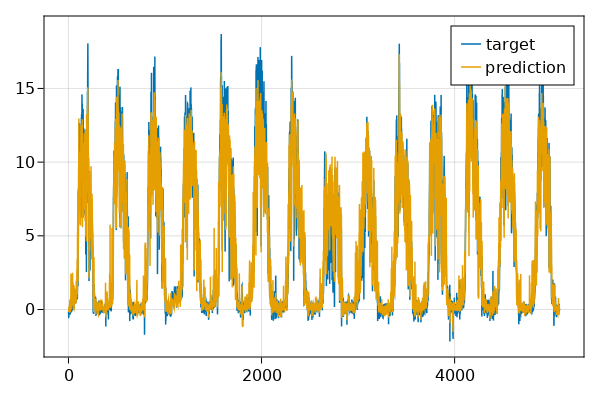

In [9]:

function plottarget(y, ŷ)
    lines(y; label = "target", figure = (; resolution = (600, 400)))
    lines!(ŷ; label = "prediction")
    axislegend()
    current_figure()
end
plottarget(y, ŷ)

It looks like we have something reasonable to work with. Next, **Shapley values**.

## Shapley values

**Shapley** values ([1953](https://doi.org/10.1515/9781400881970-018)).
are used to estimate how much each feature has contributed to the prediction, sometimes called "feature importance".
One way to do this is by changing the input for a feature while keeping all other feature inputs constant and seeing how much the output changes.
This repeated sampling is called the Monte Carlo method.
We can aggregate the Monte Carlo results to estimate how much a feature contributes to the outcome.

#### Correlations between forcing variables and target
Also, knowing the correlations between our variables will helps us understand better our data. We do that with the following function:

In [10]:
function getcor(X, y)
    features = propertynames(X)
    c = Float64[]
    for feat in features
        push!(c, cor(X[:, feat], y))
    end
    p = sortperm(c)
    return c[p], features[p]
end
c, features = getcor(X, y)

([-0.05927268708669334, 0.5705840337593328, 0.7177484922219637, 0.7567762294957247], [:P_m, :VPD_m, :SWin_m, :Ta_m])

We haven't plot our data yet, let's do it now.

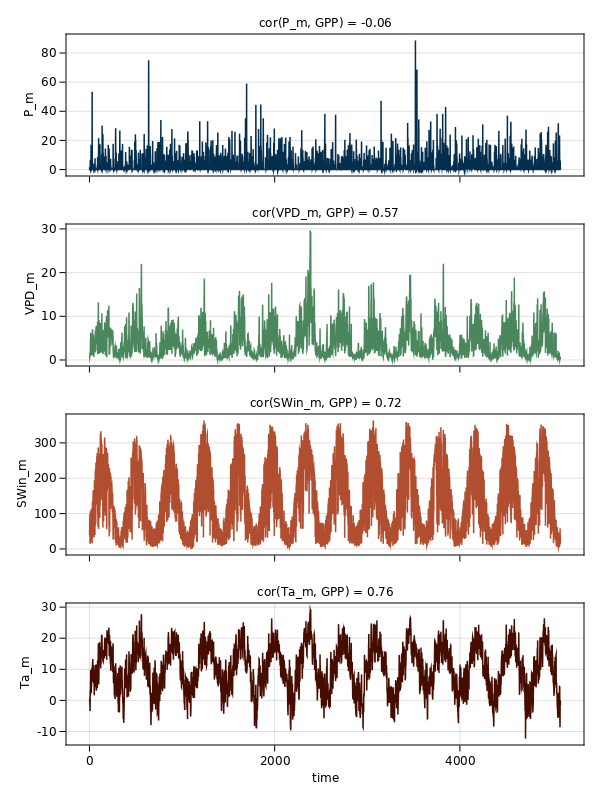

In [11]:
round2(x) = round(x; digits = 2)
function plot_data(df::DataFrame, features, corr; target = "y", cmap = :Stevens)
    colors = to_colormap(cmap, length(features))
    height = 200 * length(features)
    fig = Figure(; resolution = (600, height), fontsize = 12)
    axs = [Axis(fig[i, 1]; ylabel = string(feat)) for (i, feat) in enumerate(features)]
    for (i, (ax, feat)) in enumerate(zip(axs, features))
        lines!(ax, df[:, feat], color = colors[i])
        c = corr[i] |> round2
        ax.title = "cor($(feat), $target) = $c"
    end
    hidexdecorations!.(axs[1:end-1]; ticks = false)
    axs[end].xlabel = "time"
    fig
end
plot_data(X, features, c; target = "GPP")

Note that the panels are ordered according to their correlation with GPP. Now, calculating all Shapley values is done via the following function:

In [12]:
function shapley_values(X, m)
    return shapley(x -> predict(m, x), MonteCarlo(512), X)
end
shapleyvals = shapley_values(X, m)
DataFrame(shapleyvals)

,Ta_m,P_m,SWin_m,VPD_m
,Float64,Float64,Float64,Float64
1,-2.96721,0.112994,-1.62739,0.228948
2,-2.90982,-0.158615,-1.83281,0.213563
3,-3.23032,-0.22567,-1.08479,0.255775
4,-3.11003,-0.191104,-1.34637,0.173069
5,-3.5814,-0.188293,-0.665349,0.167702
6,-2.66535,-0.118042,-1.69357,-0.0201114
7,-2.48975,-0.097338,-1.97258,-0.0116579
8,-2.66713,-0.203406,-1.3378,0.0349006
9,-2.72435,0.204436,-1.84915,0.00160812


A more visual representation for the previous DataFrame can be done as follows(it's just plotting :D):

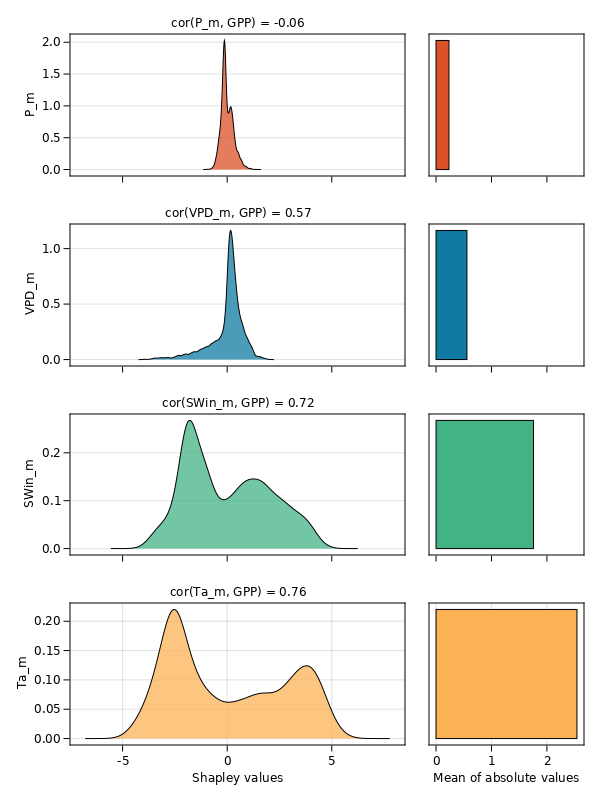

In [13]:
function plot_shapley_values(shapleyvals, features, corrs; cmap = :Egypt, target = "y")
    height = 200 * length(features)
    colors = to_colormap(cmap, length(features))
    fig = Figure(; resolution = (600, height), fontsize = 12)
    density_axs = [Axis(fig[i, 1:2]; ylabel = string(feat)) for (i, feat) in enumerate(features)]
    for (i, (ax, feat)) in enumerate(zip(density_axs, features))
        values = shapleyvals[feat]
        density!(ax, values; color = (colors[i], 0.75), strokewidth = 1)
        ax.title = "cor($(feat), $target) = $(round2(corrs[i]))"
    end
    linkxaxes!(density_axs...)
    hidexdecorations!.(density_axs[1:end-1]; ticks = false)
    density_axs[end].xlabel = "Shapley values"
    bar_axs = [Axis(fig[i, 3]) for (i, feat) in enumerate(features)]
    for (i, (ax, feat)) in enumerate(zip(bar_axs, features))
        values = shapleyvals[feat]
        meanabs = mean(abs.(values))
        barplot!(ax, [1], [meanabs]; direction = :x, color = colors[i], strokewidth = 1)
    end
    linkxaxes!(bar_axs...)
    hideydecorations!.(bar_axs)
    hidexdecorations!.(bar_axs[1:end-1]; ticks = false)
    bar_axs[end].xlabel = "Mean of absolute values"
    fig
end
plot_shapley_values(shapleyvals, features, c; target = "GPP")

It is common practice to compute statistics of the Shapley values such as the mean absolute value, root mean square or standard deviation to describe the overall feature importance. See that in the previous plot we are plotting the density distribution as well as the **mean of absolute values**.
It looks like temperature (what a surprise :D), which has the strongest correlation is also the main feature, and precipitation is the smallest contributor.

### Have fun!